# Quantification of Hysteresis Data using Cauchy Distribution Functions

Magnetic hysteresis data is typically reported in literature by plotting the data and recording the values of the saturation magnetization, coercive field, and sometimes the remnant magnetization. These values do a poor job of capturing the full field dependence of the data and, in the case of molecular magnetism, completely miss features related to quantum tunneling of magnetization or other phenomenon causing step-like behavior in the hysteresis data.

The Rinehart group has published papers studying magnetic hysteresis data of both magnetic nanoparticles ([Kirkpatrick, et al. Chem. Sci. 2023](https://pubs.rsc.org/en/content/articlelanding/2023/SC/D3SC02113K)) and single molecule magnets ([Orlova, et al. JACS 2023](https://pubs.acs.org/doi/full/10.1021/jacs.3c08946#)) using a method of quantification based on fitting the data to a Cauchy distribution function. The original code for these works were initially published in [cauchy_single](https://github.com/RinehartGroup/Cauchy_Single) and [multi_cauchy](https://github.com/RinehartGroup/multi_cauchy), and has been refactored to work in the MagnetoPy system.

For M vs. H data that is compatible with the `MvsH` class in MagnetoPy, the `CauchyCDFAnalysis` and `CauchyPDFAnalysis` classes comply with the `Analysis` protocol defined by MagnetoPy and will work seamlessly within `Magnetometry` objects, as shown below.

Data in experimental forms or otherwise not compatible with the `MvsH` class can be analyzed using the `fit_cauchy_cdf` and `fit_cauchy_pdf` functions, as shown later in this notebook.

Though not necessary, all class and function calls in this notebook will use keyword arguments to make the code more readable.

In [1]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import magnetopy as mp

dset5 = mp.Magnetometry(Path("../../tests/data/dataset5"))
dset6 = mp.Magnetometry(Path("../../tests/data/dataset6"))

## Working with MagnetoPy-compatible Data

### Single-Term Example

"dset5" contains a 300 K M vs. H dataset of a magnetite nanoparticle from [Kirkpatrick, et al. Chem. Sci. 2023](https://pubs.rsc.org/en/content/articlelanding/2023/SC/D3SC02113K).

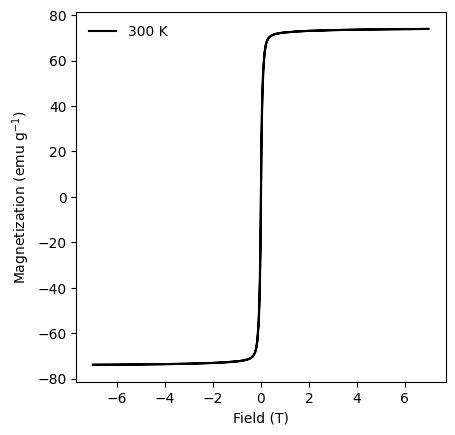

In [2]:
fig, ax = dset5.plot_mvsh()

Following the MagnetoPy `Analysis` protocol, the `CauchyCDFAnalysis` and `CauchyPDFAnalysis` classes take arguments: `dataset`, `parsing_args`, and `fitting_args`. The `parsing_args`, in general, take the arguments required to navigated the dataset and extract the specific data to be fit. In this case we'll select the M vs. H experiment at 300 K.

The `fitting_args` argument accepts either a `CauchyFittingArgs` object or an `int` representing the number of Cauchy terms to use in the fit. In a simple case like this one, simply providing the number of terms is sufficient and the automatically generated starting parameters will be close enough. 

In [3]:
nano_cauchy_cdf1 = mp.CauchyCDFAnalysis(
    dataset=dset5,
    parsing_args=mp.CauchyParsingArgs(
        temperature=300,
    ),
    fitting_args=1,
)

The results of the fit are readily plotted with the `plot()` method.

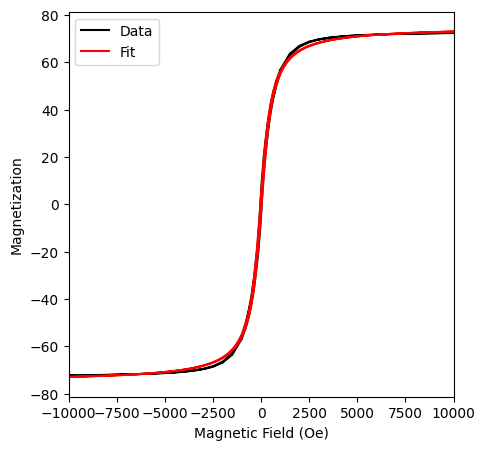

In [4]:
fig, ax = nano_cauchy_cdf1.plot()

Serialization of the `CauchyCDFAnalysis` and `CauchyPDFAnalysis` objects provides all information needed to reproduce the fit and plot.

In [5]:
print(json.dumps(nano_cauchy_cdf1.as_dict(), indent=4, default=lambda x: x.as_dict()))

{
    "_class_": "CauchyCDFAnalysis",
    "parsing_args": {
        "temperature": 300,
        "segments": "auto",
        "experiment": "MvsH",
        "_class_": "CauchyParsingArgs"
    },
    "fitting_args": {
        "_class_": "CauchyFittingArgs",
        "terms": [
            {
                "_class_": "CauchyParams",
                "m_s": [
                    73.96080646358534,
                    0,
                    110.941209695378
                ],
                "h_c": [
                    0.05078125,
                    -70000.3515625,
                    70000.453125
                ],
                "gamma": [
                    14000.08046875,
                    0,
                    140000.8046875
                ]
            }
        ]
    },
    "results": {
        "_class_": "CauchyAnalysisResults",
        "terms": [
            {
                "m_s": 75.03724020620552,
                "m_s_err": 0.11925848772738318,
                "h_c": -34.3

Note how the units of the fit are `"unknown"` by default. They can be set using the `set_units()` method of the `CauchyAnalysisResults` class.

In [6]:
nano_cauchy_cdf1.results.set_units(
    m_s="emu/g",
    h_c="Oe",
    gamma="Oe",
    chi_pd="emu/g/Oe",
)

The same process is used to fit the derivative of magnetization with respect to field to a Cauchy probability density function. The `CauchyPDFAnalysis` class is used for this purpose.

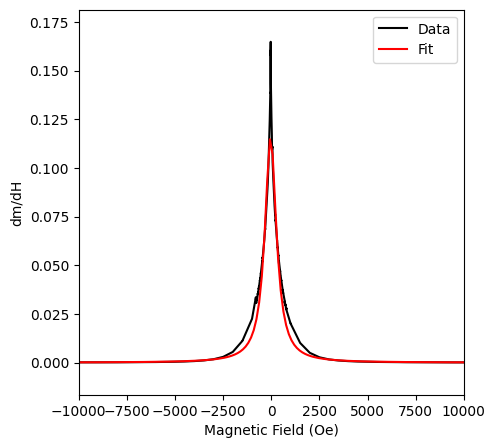

In [7]:
nano_cauchy_pdf1 = mp.CauchyPDFAnalysis(
    dataset=dset5,
    parsing_args=mp.CauchyParsingArgs(
        temperature=300,
    ),
    fitting_args=1,
)
nano_cauchy_pdf1.results.set_units(
    m_s="emu/g",
    h_c="Oe",
    gamma="Oe",
    chi_pd="emu/g/Oe",
)
fig, ax = nano_cauchy_pdf1.plot()

As was shown in the ["Datasets in MagnetoPy: The `Magnetometry` Class" example notebook](../magnetometry.ipynb), the results of the analyses can be serialized along with the rest of the dataset by adding the analyses to the `Magnetometry` object and creating a json report. [The report can be viewed here](../dataset5.json)

In [8]:
dset5.add_analysis([nano_cauchy_cdf1, nano_cauchy_pdf1])
dset5.create_report()

Report written to ..\..\tests\data\dataset5\dataset5.json


### Multi-Term Example

`"dset6"` contains M vs. H data from a single-molecule magnet described in [Orlova, et al. JACS 2023](https://pubs.acs.org/doi/full/10.1021/jacs.3c08946#). There are several temperatures and the hysteresis curves have several features that require multiple Cauchy terms to properly fit.

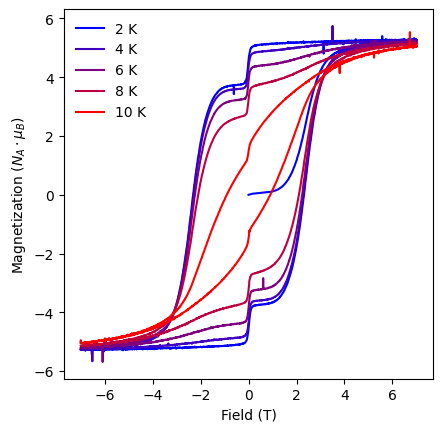

In [9]:
fig, ax = dset6.plot_mvsh()

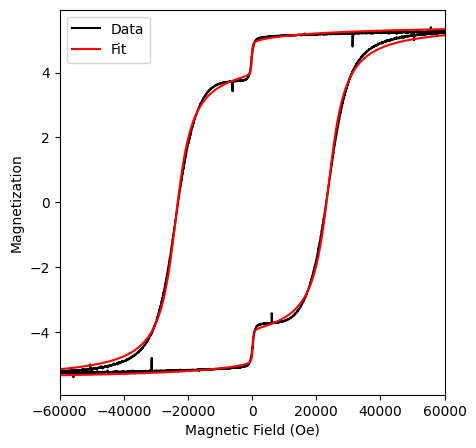

In [31]:
smm_cauchy_cdf1 = mp.CauchyCDFAnalysis(
    dataset=dset6,
    parsing_args=mp.CauchyParsingArgs(
        temperature=2,
    ),
    fitting_args=3,
)
fig, ax = smm_cauchy_cdf1.plot(xlim=[-60000, 60000])

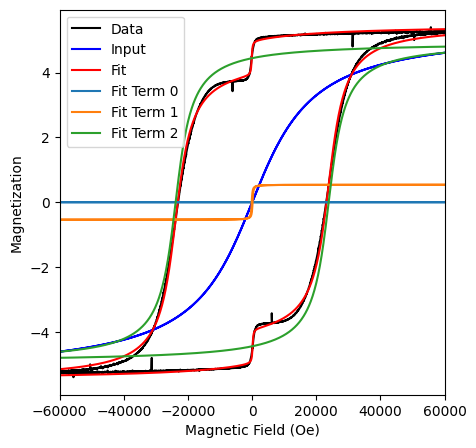

In [32]:
fig, ax = smm_cauchy_cdf1.plot(
    show_full_fit=True,
    show_fit_components=True,
    show_input=True,
    xlim=[-60000, 60000],
)

In [13]:
kyle = Path("orlova.json")
kyle = json.loads(kyle.read_text())
for meas in kyle['measurements']:
    temp = meas['temperature']
    input_params = meas['fit_input_params']
    print(f"Temperature: {temp}")
    for param in input_params:
        print(f"\tm_s: {param['m_s']}\th_c: {param['h_c']}\tgamma: {param['gamma']}")

Temperature: 2.0
	m_s: [0.05, 0.0001, 0.2]	h_c: [-20000, -60000, -5000]	gamma: [25000, 5000, 200000]
	m_s: [0.5, 0, 1.0]	h_c: [0, -100, 100]	gamma: [100, 5, 1000]
	m_s: [0.5, 0, 1]	h_c: [15000, 10000, 30000]	gamma: [10000, 2500, 40000]
Temperature: 4.0
	m_s: [0.05, 0.0001, 0.2]	h_c: [-20000, -60000, -5000]	gamma: [25000, 5000, 200000]
	m_s: [0.5, 0, 1.0]	h_c: [0, -100, 100]	gamma: [100, 5, 1000]
	m_s: [0.5, 0, 1]	h_c: [15000, 10000, 30000]	gamma: [10000, 2500, 40000]
Temperature: 6.0
	m_s: [0.05, 0.0001, 0.2]	h_c: [-20000, -60000, -5000]	gamma: [25000, 5000, 200000]
	m_s: [0.5, 0, 1.0]	h_c: [0, -100, 100]	gamma: [100, 5, 1000]
	m_s: [0.5, 0, 1]	h_c: [15000, 10000, 30000]	gamma: [10000, 2500, 40000]
Temperature: 8.0
	m_s: [0.05, 0.0001, 0.2]	h_c: [-20000, -60000, -5000]	gamma: [25000, 5000, 200000]
	m_s: [0.5, 0, 1.0]	h_c: [0, -100, 100]	gamma: [100, 5, 1000]
	m_s: [0.5, 0, 1]	h_c: [15000, 10000, 30000]	gamma: [10000, 2500, 40000]
Temperature: 10.0
	m_s: [0.05, 0.0001, 0.2]	h_c: [-20000

In [28]:
for meas in kyle['measurements']:
    temp = meas['temperature']
    output_params = meas['cdf_fit']['output_params']['params']
    print(f"Temperature: {temp}")
    for i, param in enumerate(output_params):
        print(f"{param[0], param[1]}")
    print()

Temperature: 2.0
('m_s_0', 0.065406496174004)
('h_c_0', -47841.24148224168)
('gamma_0', 22696.525897845968)
('m_s_1', 0.09585617046052752)
('h_c_1', 62.48261576736189)
('gamma_1', 194.61236531267423)
('m_s_2', 0.9429908949362917)
('h_c_2', 24004.36113546808)
('gamma_2', 4592.309244105287)
('chi_pd', -1.823742858286792e-06)

Temperature: 4.0
('m_s_0', 0.0963799322637117)
('h_c_0', -37779.23982260618)
('gamma_0', 24882.31419210621)
('m_s_1', 0.08605238457452558)
('h_c_1', 16.961076251600062)
('gamma_1', 168.25808830367956)
('m_s_2', 0.9192188806902738)
('h_c_2', 23923.132164388473)
('gamma_2', 4547.956106773863)
('chi_pd', -1.763488898687271e-06)

Temperature: 6.0
('m_s_0', 0.13595948330975005)
('h_c_0', -31172.836388275537)
('gamma_0', 20747.75986367555)
('m_s_1', 0.07367851878241866)
('h_c_1', -0.7489013832626625)
('gamma_1', 120.00086073978422)
('m_s_2', 0.862250084089228)
('h_c_2', 23693.940976119455)
('gamma_2', 4609.020090485088)
('chi_pd', -1.4465315126832579e-06)

Temperature: 8.

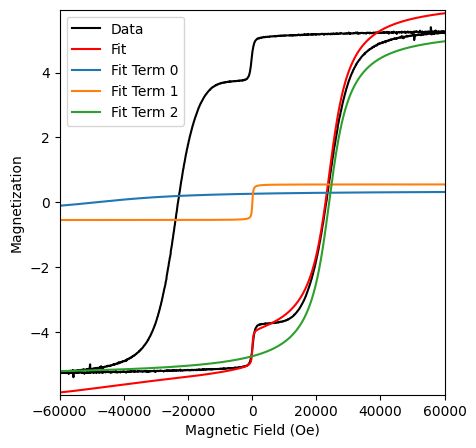

In [33]:
fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(
            m_s=(0.05, 0.0001, 0.2),
            h_c=(-20000, -60000, -5000),
            gamma=(25000, 5000, 200000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1.0),
            h_c=(0, -100, 100),
            gamma=(100, 5, 1000)
        ),
        mp.CauchyParams(
            m_s=(0.5, 0, 1),
            h_c=(15000, 10000, 30000),
            gamma=(10000, 2500, 40000)
        )
    ]
)
m_sat = dset6.get_mvsh(2).simplified_data()['moment'].max()
for arg in fitting_args.terms:
    arg.m_s = (m_sat * arg.m_s[0], m_sat * arg.m_s[1], m_sat * arg.m_s[2])

smm_cauchy_cdf2 = mp.CauchyCDFAnalysis(
    dataset=dset6,
    parsing_args=mp.CauchyParsingArgs(
        temperature=2,
    ),
    fitting_args=fitting_args,
)
fig, ax = smm_cauchy_cdf2.plot(
    segment="forward",
    show_full_fit=True,
    show_fit_components=True,
    xlim=[-60000, 60000],
)

Temperature: 2.0

- ('m_s_0', 0.065406496174004)
- ('h_c_0', -47841.24148224168)
- ('gamma_0', 22696.525897845968)
- ('m_s_1', 0.09585617046052752)
- ('h_c_1', 62.48261576736189)
- ('gamma_1', 194.61236531267423)
- ('m_s_2', 0.9429908949362917)
- ('h_c_2', 24004.36113546808)
- ('gamma_2', 4592.309244105287)
- ('chi_pd', -1.823742858286792e-06)

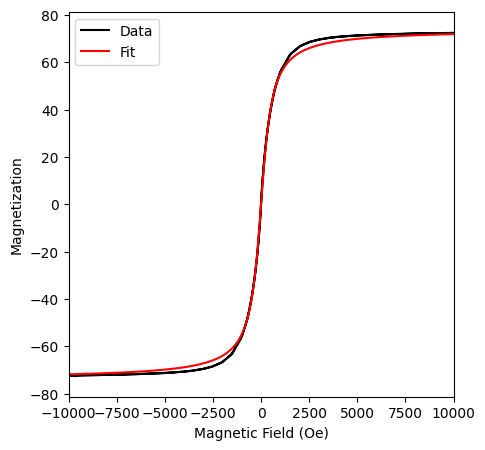

In [4]:
np_cauchy_cdf = mp.CauchyCDFAnalysis(dset5, mp.CauchyParsingArgs(300), 1)
fig, ax = np_cauchy_cdf.plot()

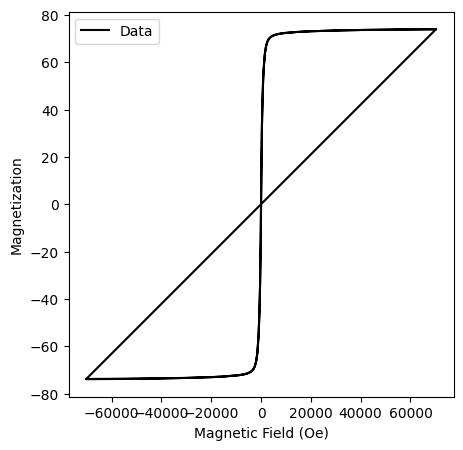

In [2]:
data = mp.CauchyParsingArgs(300).prepare_data(dset5, "cdf")
fig, ax = mp.plot_cauchy_cdf(data['h'], data['target'])

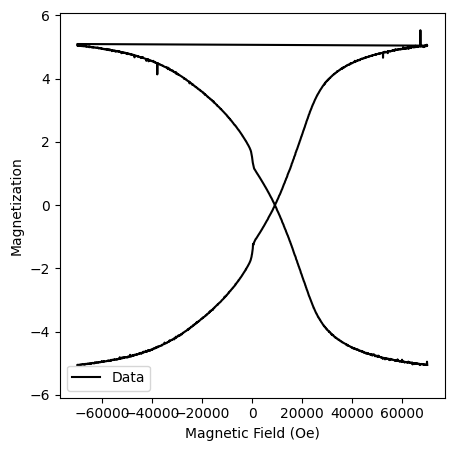

In [30]:
data = mp.CauchyParsingArgs(10).prepare_data(dset6, "cdf")
fig, ax = mp.plot_cauchy_cdf(data['h'], data['target'])

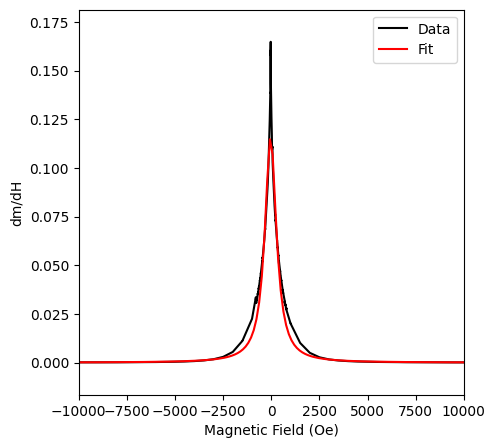

In [18]:
# np_cauchy_pdf = mp.CauchyPDFAnalysis(dset5, mp.CauchyParsingArgs(300), 1) # mp.CauchyFittingArgs([mp.CauchyParams(75, 0, 5000)]))
np_cauchy_pdf = mp.CauchyPDFAnalysis(dset5, mp.CauchyParsingArgs(300), mp.CauchyFittingArgs([mp.CauchyParams(75, 0, 5000)]))
fig, ax = np_cauchy_pdf.plot()

In [21]:
np_cauchy_cdf.fitting_args.as_dict()

{'_class_': 'CauchyFittingArgs',
 'terms': [{'_class_': 'CauchyParams',
   'm_s': (75, 0, 73.95358311822676),
   'h_c': (0, -70000.09375, 70000.3515625),
   'gamma': (5000, 0, 140000.4453125)}]}

In [20]:
np_cauchy_pdf.results.as_dict()

{'_class_': 'CauchyAnalysisResults',
 'terms': [{'m_s': 65.48294869409973,
   'm_s_err': 1.0536651347956185,
   'h_c': -33.8293994369742,
   'h_c_err': 3.000743545212988,
   'gamma': 1438.498723909016,
   'gamma_err': 22.96705263566427}],
 'chi_pd': 0.003279462912358902,
 'chi_pd_err': 0.0006301748196558242,
 'chi_squared': 0.022849434304085692,
 'reduced_chi_squared': 5.1695552724175774e-05,
 'm_s_unit': 'unknown',
 'h_c_unit': 'unknown',
 'gamma_unit': 'unknown',
 'chi_pd_unit': 'unknown'}

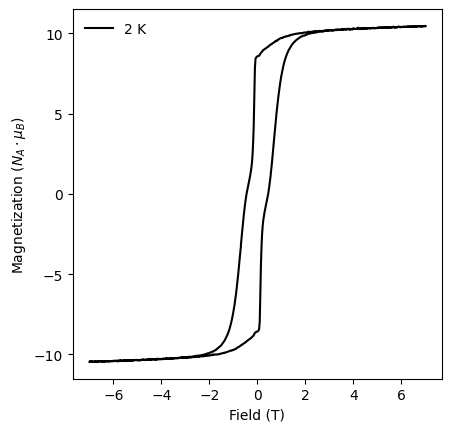

In [2]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
mvsh = dset1.get_mvsh(2)
fig, ax = mvsh.plot()

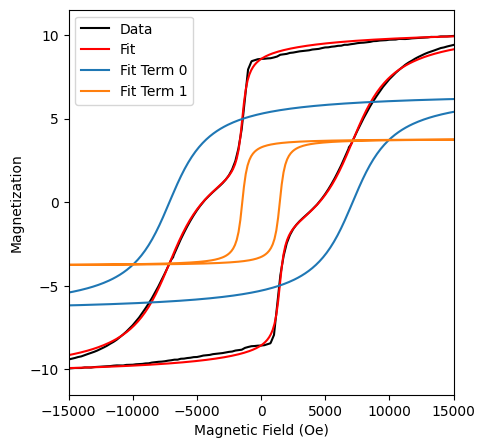

In [3]:
df = mvsh.simplified_data("forward").copy()

cdf_results1 = mp.fit_cauchy_cdf(df['field'], df['moment'], 2)
fig, ax = mp.plot_cauchy(df['field'], df['moment'], "cdf", cdf_results1, True, True, True, True)

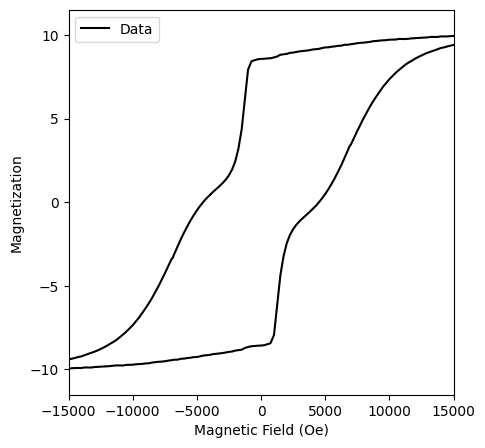

In [4]:
cauchy_cdf1 = mp.CauchyCDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), 2)
fig, ax = cauchy_cdf1.plot()

In [6]:
cauchy_cdf1.results.as_dict()

{'_clas_': 'CauchyAnalysisResults',
 'terms': [{'m_s': 6.610598547123777,
   'm_s_err': 0.05580388232400879,
   'h_c': 7137.957149588925,
   'h_c_err': 35.427350521770364,
   'gamma': 2314.3686488975873,
   'gamma_err': 35.488033882001446},
  {'m_s': 3.7975696757068733,
   'm_s_err': 0.044687186980549465,
   'h_c': 1460.7209273816843,
   'h_c_err': 11.618656040335692,
   'gamma': 320.9722659438162,
   'gamma_err': 15.786066914387193}],
 'chi_pd': 3.3719609901027864e-06,
 'chi_pd_err': 3.5652340244556424e-07,
 'chi_squared': 6.847222126034497,
 'reduced_chi_squared': 0.01231514770869514,
 'm_s_unit': 'unknown',
 'h_c_unit': 'unknown',
 'gamma_unit': 'unknown',
 'chi_pd_unit': 'unknown'}

In [ ]:
df = mvsh.simplified_data("forward").copy()
df['dmdh'] = np.gradient(df['moment'], df['field'])

results1 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], 2)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results1)

In [ ]:
df = mvsh.simplified_data("forward").copy()
df['dmdh'] = np.gradient(df['moment'], df['field'])

results1 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], 2)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results1, False, True)

In [6]:
fitting_args = mp.CauchyFittingArgs(
    [
        mp.CauchyParams(5, 1000, 2000),
        mp.CauchyParams(8, 7000, 10000),
    ]
)
results2 = mp.fit_cauchy_pdf(df['field'], df['dmdh'], fitting_args)
fig, ax = mp.plot_cauchy_pdf(df['field'], df['dmdh'], results2)

KeyError: 'dmdh'

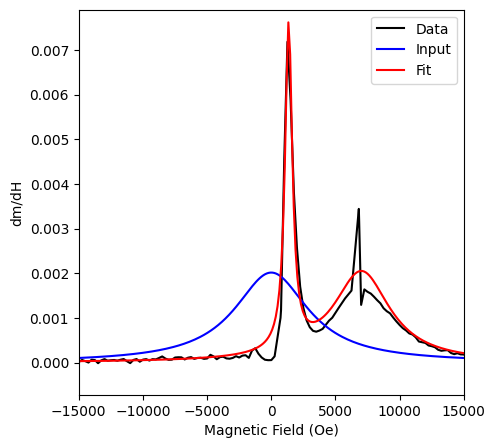

In [7]:
cauchy1 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), 2)
fig, ax = cauchy1.plot(input_params = True)

In [10]:
test = fitting_args.generate_data(np.linspace(-5, 5, 10), "cdf")
type(test)

numpy.ndarray

In [11]:
list(test)

[-4.594306446299831,
 -4.592514622348293,
 -4.5907221295115725,
 -4.5889289679240575,
 -4.587135137721255,
 -4.585340639039783,
 -4.5835454720173825,
 -4.581749636792914,
 -4.579953133506356,
 -4.578155962298815]

In [ ]:
cauchy2 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "forward"), fitting_args)
fig, ax = cauchy2.plot(input_params = True)

In [ ]:
cauchy3 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2, "reverse"), fitting_args)
fig, ax = cauchy3.plot(input_params = True)

In [ ]:
cauchy4 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2), fitting_args)
fig, ax = cauchy4.plot(input_params = True)

In [5]:
cauchy4 = mp.CauchyPDFAnalysis(dset1, mp.CauchyParsingArgs(2), fitting_args)
fig, ax = cauchy4.plot(False, True)

NameError: name 'fitting_args' is not defined